# BENVGSC5 - UCL CASA: Urban Simulation
# Unconstrained Gravity Model

This notebook reproduces Adam Dennett's guide to spatial interaction models in Python, see his original R version here: https://rpubs.com/adam_dennett/257231

NB: Although the procedure is essentially identical, some small differences in how python vs. R computes polygon centroids means that some distances are slightly different, leading to slightly different numbers of flows. Goodness of fit is the same to a couple of decimal places though.

## Getting started

Below I import the libraries I use in the practical. Pandas and Geopandas are the main ones, allowing for the easy manipulation of tabular and spatial data. I do most of the plotting in matplotlib, but I also import seaborn later on to fulfill a specific visualisation purpose. You only currently need shapely as geopandas doesn't read geojsons directly from urls, for now, so requests gets the geojson and shapely handles the geometries. numpy is python's numerical workhorse providing fast maths, and statsmodels is for the GLM later.

In general, I found python made the setup much easier and clearer than R, but R has advantages in terms of visualisation.

NB This is written in python 2.

In [32]:
# Some necessary packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from shapely.geometry import shape, LineString
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

% matplotlib inline

# Set up some spatial data

Our spatial data comes direct from the UK Government statistics geoportal in the geojson format. Unfortunately, GeoPandas currently can't read directly from urls, so we have a few extra lines to set up the geodataframe.

Note that I transform the data at the end, from the starting geographic projection 'WGS84', which locates features using angular coordinates - degrees from the Greenwich Meridian (longitude) and degrees from the equator (latitude), to the British National Grid, a projected coordinate system that flattens the earth, and locates features in Great Britain according to their distance in metres from an origin (0,0) off of the coast of Cornwall in the South West of the country.

Projecting the data will mean that when you measure distances later they'll be in metres, and not angular units (degrees, minutes, seconds; decimal degrees etc.)

In [2]:
# Get a geojson of GB districts from the ONS Geoportal. Geopandas doesn't really implement this well yet,
# so this is a bit more difficult than it should be...

# Define url
district_url = "http://geoportal.statistics.gov.uk/datasets/8edafbe3276d4b56aec60991cbddda50_2.geojson"
# Access data using requests http library, take the features info direct from the json
districts_json = requests.get(district_url).json()['features']

# Each district has 3 pieces of information: geometry, type, and properties.
# We can ignore type here, geometry is self explanatory, properties are our attributes.
# To put the data into geopandas we need to split it into geometry and attribute lists.
# geometry - list of shapely geometries
geom = [shape(d['geometry']) for d in districts_json]
# Attributes - list of dictionaries
attr = [d['properties'] for d in districts_json]

# Now put data into geopandas geodataframe, set input crs to WGS84
districts = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})

# Finally, because we know we'll be measuring distances later, we'll project to the British National Grid.
districts = districts.to_crs({'init':'epsg:27700'})

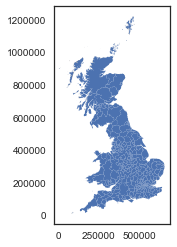

In [33]:
# lets just see how that looks
districts.plot();

In [4]:
# We just want to work with London, so we need to extract that.
# As it happens, the London prefix for the field: lad15cd is 'E09', so we can subset using string processing methods.
london = districts[districts['lad15cd'].str.contains('E09')]

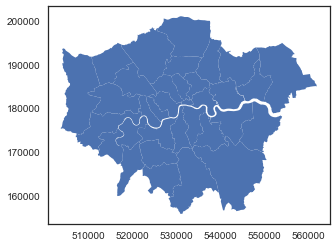

In [34]:
# Quick check to make sure we've got London!
london.plot();

# Flow Data

The data we are going to use to test our spatial interaction models with is commuting data from the 2001 England and Wales Census. In the Census, there is a question which asks your home address and another which asks the location of your usual place of work, as well as the method of transport that you mainly use to conduct your commute. From this, estimates of commuter flows by transportation type for the whole country can be generated.

In this exercise, to save time, Dr. Dennett has already downloaded some sample data which records the place (Borough) of residence and place (Borough) of work for all people living in London at the time of the 2001 Census. Borough level is quite coarse, but it will suffice for demonstration. If you would like to download your own commuting or migration flow data, then you should visit the Census Support Flow Data Service called wicid - https://wicid.ukdataservice.ac.uk/ - here you can download flows for a huge range of geographies from the 1981, 1991, 2001 and 2011 Censuses.

As well as flow data, Dr. Dennett has also collated some additional data on income, the number of jobs in each borough in 2001 and the total population - we will use these as destination attractiveness / mass term and origin emissiveness / mass term proxies in the models which follow.

The data is available (currently) as a link to Dr. Dennett's dropbox, luckily Pandas can read csv files directly from urls!

In [6]:
# Read in some flow data from a csv stored on dropbox.
# Initially we'll read this data into pandas, which can read from urls directly!

# commuting data.
cdata = pd.read_csv("https://www.dropbox.com/s/7c1fi1txbvhdqby/LondonCommuting2001.csv?raw=1")
# population and income data
popincome = pd.read_csv("https://www.dropbox.com/s/84z22a4wo3x2p86/popincome.csv?raw=1")

# Unfortunately the commuting data uses the old ONS geography codes, so we also need a converter :(
codelookup = pd.read_csv("https://www.dropbox.com/s/h8mpvnepdkwa1ac/CodeLookup.csv?raw=1")

In [7]:
# The first thing I'm going to do is merge the new codes with the commuting data.
# We need to do this twice, once for origin codes, and once for destination codes.

# Join newcode to cdata for origins
cdata = cdata.merge(codelookup,left_on='OrigCode',right_on='OldCode')
# Tidy up join. Drop unecessary fields
cdata.drop(['OldCode','Label'], axis=1, inplace=True)
# Rename NewCode column to reference origin
cdata.rename(columns={'NewCode':'OrigNewCode'}, inplace=True)

# Join newcode to cdata for destinations
cdata = cdata.merge(codelookup,left_on='DestCode',right_on='OldCode')
# Tidy up join. Drop unecessary fields
cdata.drop(['OldCode','Label'], axis=1, inplace=True)
# Rename NewCode column to reference origin
cdata.rename(columns={'NewCode':'DestNewCode'}, inplace=True)

In [8]:
# Now we are going to merge in the district populations and median incomes to commuting origins and destinations

# Origins - merge, tidy, rename
cdata = cdata.merge(popincome[['code','pop','med_income']], left_on = 'OrigNewCode', right_on = 'code')
cdata.drop(['code'], axis=1, inplace=True)
cdata.rename(columns={'pop':'vi1_origpop','med_income':'vi2_origsal'}, inplace=True)

# Destinations - merge, tidy, rename
cdata = cdata.merge(popincome[['code','pop','med_income']], left_on = 'DestNewCode', right_on = 'code')
cdata.drop(['code'], axis=1, inplace=True)
cdata.rename(columns={'pop':'wj1_destpop','med_income':'wj2_destsal'}, inplace=True)

In [9]:
# Quick look at how our cdata pandas dataframe now looks.
cdata.head()

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,...,Motobike,Bicycle,Walk,Other,OrigNewCode,DestNewCode,vi1_origpop,vi2_origsal,wj1_destpop,wj2_destsal
0,City of London,00AA,City of London,00AA,2059,432,120,53,50,31,...,3,18,1272,41,E09000001,E09000001,12000,38300,12000,38300
1,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,1788,55,0,...,63,9,11,0,E09000002,E09000001,56000,16200,12000,38300
2,Barnet,00AC,City of London,00AA,7709,0,4948,1779,133,16,...,111,25,10,8,E09000003,E09000001,159000,18700,12000,38300
3,Bexley,00AD,City of London,00AA,6580,0,60,5697,45,6,...,167,20,10,6,E09000004,E09000001,112000,18300,12000,38300
4,Brent,00AE,City of London,00AA,4145,0,3327,372,90,3,...,38,37,13,3,E09000005,E09000001,127000,16500,12000,38300


# Calculate Distances

Note, I'm doing the distance calculation slightly differently than in Dr. Dennett's R practical. If you want to take a similar distance matrix/pair-wise distance approach you can use pdist and cdist in scipy's spatial module.

Here I apply a function iteratively to my pandas dataframe of flows, which pulls in the origin and destination codes, the london geodataframe and the zonecode that identifies geographies in the geodataframe, and return the distance between each origin and destination using geopandas's distance method. It might be a little less efficient than Dr. Dennett's approach, but I'm more confident that I know how it works. 

The important spatial data for spatial interaction models relates to the cost of interaction between places and this is very frequently represented through distance.

In [10]:
# Now we need to generate the pairwise distances for each flow.
# We'll do this with a general function that returns the distance between two polygon centroids using a geopandas dataframe.
# This isn't very optimal, but should be sufficient for our purposes.

def pairdist(orig,dest,geo,zonecode):
    return geo[geo[zonecode] == orig].centroid.values[0].distance(geo[geo[zonecode] == dest].centroid.values[0])

# apply the function row-wise for all rows in the commuting data.
cdata['dist'] = cdata.apply(lambda x: pairdist(x['OrigNewCode'],x['DestNewCode'],london,'lad15cd'),axis=1)

# Also, create a new Total column ('TotalNoIntra') that sets self-flows to 0, and otehrwise to Total.
cdata['TotalNoIntra'] = np.where(cdata['OrigCode'] == cdata['DestCode'], 0, cdata['Total'])

# Now, create a field called offset which sets intra borough flows from 0 to a v.small number, and 1 otherwise.
cdata['offset'] = np.where(cdata['OrigCode'] == cdata['DestCode'],0.0000000001,1)

# Now we have a master dataset of London flows! Check it out!
cdata.head()

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,...,Other,OrigNewCode,DestNewCode,vi1_origpop,vi2_origsal,wj1_destpop,wj2_destsal,dist,TotalNoIntra,offset
0,City of London,00AA,City of London,00AA,2059,432,120,53,50,31,...,41,E09000001,E09000001,12000,38300,12000,38300,0.000000,0,1.000000e-10
1,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,1788,55,0,...,0,E09000002,E09000001,56000,16200,12000,38300,16021.038518,3641,1.000000e+00
2,Barnet,00AC,City of London,00AA,7709,0,4948,1779,133,16,...,8,E09000003,E09000001,159000,18700,12000,38300,13906.457441,7709,1.000000e+00
3,Bexley,00AD,City of London,00AA,6580,0,60,5697,45,6,...,6,E09000004,E09000001,112000,18300,12000,38300,17310.372126,6580,1.000000e+00
4,Brent,00AE,City of London,00AA,4145,0,3327,372,90,3,...,3,E09000005,E09000001,127000,16500,12000,38300,13119.230793,4145,1.000000e+00


## Subset flows

For ease of demonstration, we take a subset of 7 London boroughs and the flows between them.

The subsetting of data here is, I think, a real advantage that python and pandas has over R.

In [11]:
# Let's have a look at a subset of flows
flows = ["00AA", "00AB", "00AC", "00AD", "00AE", "00AF", "00AG"]

# from cdata, we want the 42 flows that start and end as one of these 7 flows, but not the 7 self flows
# The subset selection has 3 parts: 1) OrigCode in flows; 2) DestCode in flows; 3) Origcode not equal to DestCode.
cdatasub = cdata[cdata['OrigCode'].isin(flows) & cdata['DestCode'].isin(flows) & (cdata['OrigCode'] != cdata['DestCode'])]

## Mapping flows

Mapping flows is a little tricker in python, but I've written the basic function to make a flows geodataframe, which should then be extensible. it should be more of less doing what the od2line function doe sin R.

Although I haven't given an example using slippy maps, like Dr. Dennett uses leaflet in R, the same effect can be obtained using python's "fusion" package. You can reproject the flows to WGS84 and pass the geodataframe directly to fusion and you'll get the same embedded map as with leaflet.

The clever thing that is happening in the static plot below is that I'm applying a function to the flows dataframe which is performed on each row in the dataframe and returns a series object the same length as the dataframe which gives a value for the width of each line. This goes straight into the plot method as a parameter and draws the varying width lines in the plot.

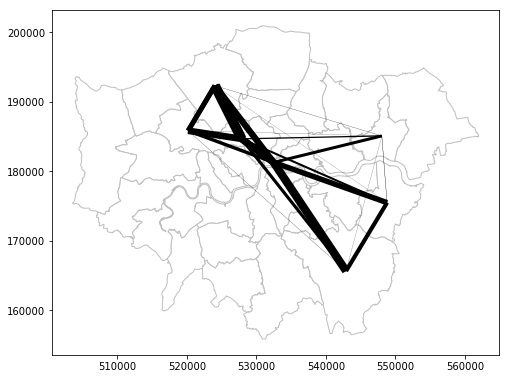

In [12]:
# Let's make a function to convert these flows to a geopandas dataframe so that we can draw them.
# Again, this is not super efficient, but is fine for our purposes.

# makes lines from origin destination inputs and known geography
# Don't call this, it is used by the function odflow.
def _odline(orig,dest,geo,zonecode):
    return LineString([geo[geo[zonecode] == orig].centroid.values[0],geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata,origin,destination,flow_value,geo,zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin],x[destination],geo,zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[flow_value]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows,geometry=lines,crs = geo.crs)

# Get the flows geodataframe
flows = odflow(cdatasub,'OrigNewCode','DestNewCode','Total',london,'lad15cd')

# Now lets create a neat plot of the flows.
f, ax = plt.subplots(1,figsize=(8,8))
# Plot london districts as a backdrop
london.plot(color='w', edgecolor='0.75',ax=ax)
# Work out max flow for scaling
maxflow = float(max(flows['Total']))
# Now plot flows, calculating linewidths as a function of 'Total'
flows.plot(linewidth = flows.apply(lambda x: (x['Total']/maxflow)*10,axis=1), color = 'k',ax=ax)
ax.set_aspect('equal')

Everything has now been set up, so we can move to...

# Building the Model

In explaining how to run and calibrate spatial interaction models in R, I will adopt the notation used by Taylor Oshan in his excellent primer for running spatial interation models in Python using the SpInt package. The paper is well worth a read and can be found here: http://openjournals.wu.ac.at/region/paper_175/175.html In general, the package is good for spatial interaction modelling, but we ignore it here for the purpose of gettign to grips with the practicalities of the appraoch.

Below is the classic multiplicative gravity model:

1 $$T_{ij} = k \frac{V^{\mu}_{i}W^{\alpha}_{j}}{d^{\beta}_{ij}}$$

This gravity model can be written in the form more familiar from Wilson’s 1971 paper - http://journals.sagepub.com/doi/abs/10.1068/a030001

2 $$T_{ij} = kV^{\mu}_{i}W^{\alpha}_{j}d^{-\beta}_{ij}$$

**This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversely proportional to the distance between them.**

**As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.**

- where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the $i$ and $j$ are just generic indexes to allow us to refer to any cell in the matrix more generally.
- $V$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called vi1_origpop) and a vector of origin average salaries (which I have called vi2_origsal) in 2001
- $W$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called wj1_destpop) and a vector of destination average salaries (which I have called wj2_destsal) in 2001
- $d$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is distance and it is called ‘dist’ in our dataset.
- $k$, $\mu$, $\alpha$ and $\beta$ are all model parameters to be estimated
$k$ is a constant of proportionality and leads to this particular model being more accurately described as a ‘total constrained’ model as all flows estimated by the model will sum to any observed flow data used to calibrate the parameters, where:

3 $$k = \frac{T}{\sum_{i}\sum_{j}V^{\mu}_{i}W^{\alpha}_{j}d^{-\beta}_{ij}}$$

and $T$ is the sum of our matrix of observed flows or:

4 $$T = \sum_{i}\sum_{j}T_{ij}$$

In English, this is just the sum of all observed flows divided by the sum of all of the other elements in the model.

## Estimating Model Parameters

Now, it’s perfectly possible to produce some flow estimates by plugging some arbitrary or expected estimated values into our parameters. The parameters relate to the scaling effect / importance of the variables they are associated with. Most simply, where the effects of origin and destination attributes on flows scale in a linear fashion (i.e. for a 1 unit increase in, say, population at origin, we might expect a 1 unit increase in flows of people from that origin, or for a halving in average salary at destination, we might expect a halving of commuters), $\mu = 1$ and $\alpha = 1$. In Newton’s original gravity equation, $\beta = -2$ where the influence of distance on flows follows a power law - i.e. for a 1 unit increase in distance, we have a $1^{-2}$ (1) unit decrease in flows, for a 2 unit increase in distance, we have $2^{-2}$ (0.25 or 1/4) of the flows, $3^{-2}$ (0.111) of the flows etc.

So, let's look at these as initial parameters and try predicting a model based on these guesses. For this we'll use the whole dataset.

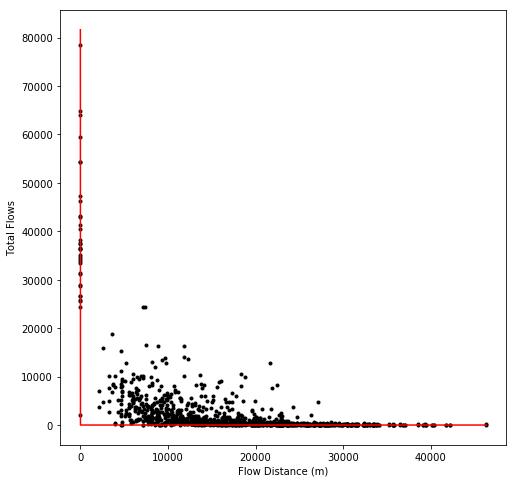

In [13]:
# Now lets create a neat plot of the flows against dist.
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(cdata['dist'],cdata['Total'],marker='.',color='k')

# now work out the function y = x^-2 - basic inverse power.
xvals = np.geomspace(0.0035,cdata['dist'].max(),1000)
yvals = np.power(xvals,-2.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Flow Distance (m)")

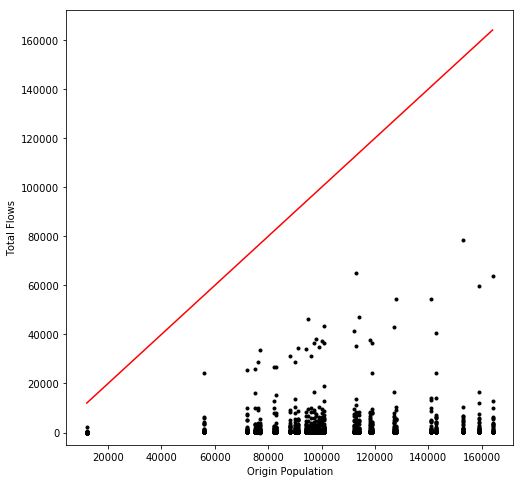

In [14]:
# Now lets create a neat plot of the flows against origin populations.
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(cdata['vi1_origpop'],cdata['Total'],marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(cdata['vi1_origpop'].min(),cdata['vi1_origpop'].max(),100)
yvals = np.power(xvals,1.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000,cdata['vi1_origpop'].max()*1.05)

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Origin Population")

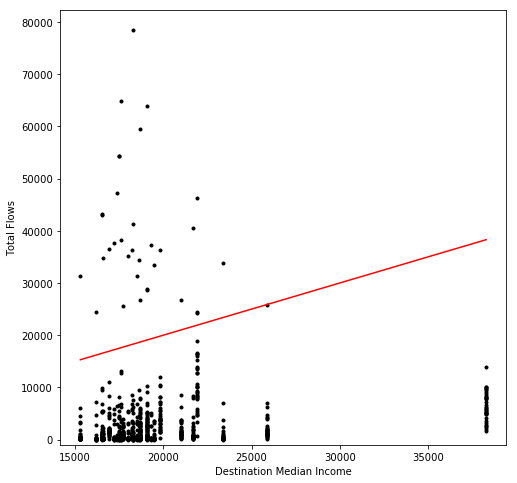

In [15]:
# Now lets create a neat plot of the flows against origin populations.
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(cdata['wj2_destsal'],cdata['Total'],marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(cdata['wj2_destsal'].min(),cdata['wj2_destsal'].max(),100)
yvals = np.power(xvals,1.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000,cdata['Total'].max()*1.05)

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Destination Median Income")

OK, so it looks like we’re not far off (well, destination salary doesn’t look too promising as a predictor, but we’ll see how we get on…), so let’s see what flow estimates with these starting parameters look like.

In [16]:
# Now for some flow estimates
# Set up some variables to hold our parameter values in:
mu = 1.0
alpha = 1.0
beta = -2.0
k = 1.0
T2 = cdatasub['Total'].sum()

Now let’s create some flow estimates using Equation 2 above… Begin by applying the parameters to the variables:

In [17]:
vi1_mu = np.power(cdatasub['vi1_origpop'],mu)
wj2_alpha = np.power(cdatasub['wj2_destsal'],alpha)
dist_beta = np.power(cdatasub['dist'],beta)
T1 = vi1_mu*wj2_alpha*dist_beta
k = T2/np.sum(T1)

Then, just as in Equation 2 above, just multiply everything together to get your flow estimates:

In [18]:
unconstrained_est1 = np.round(k*vi1_mu*wj2_alpha*dist_beta,0)
print unconstrained_est1.sum()

93803.0


In [19]:
# Attach these estimates back to cdatasub
cdatasub = cdatasub.assign(est1 = unconstrained_est1)

# Make a pivot table to look at the flow matrix
pd.pivot_table(cdatasub,values='est1',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,265.0,1760.0,189.0,422.0,434.0,1331.0,4401.0
Barnet,653.0,0.0,517.0,7344.0,453.0,6841.0,5016.0,20824.0
Bexley,3117.0,372.0,0.0,318.0,2592.0,676.0,2280.0,9355.0
Brent,422.0,6648.0,400.0,0.0,418.0,6625.0,4502.0,19015.0
Bromley,1047.0,458.0,3637.0,467.0,0.0,881.0,2839.0,9329.0
Camden,640.0,4104.0,564.0,4390.0,523.0,0.0,18794.0,29015.0
City of London,121.0,185.0,117.0,183.0,104.0,1154.0,0.0,1864.0
All,6000.0,12032.0,6995.0,12891.0,4512.0,16611.0,34762.0,93803.0


In [20]:
# What about the original flows?
pd.pivot_table(cdatasub,values='Total',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,194.0,96.0,178.0,66.0,1500.0,3641.0,5675.0
Barnet,96.0,0.0,34.0,5467.0,76.0,12080.0,7709.0,25462.0
Bexley,362.0,132.0,0.0,144.0,4998.0,2470.0,6580.0,14686.0
Brent,40.0,6124.0,28.0,0.0,66.0,8105.0,4145.0,18508.0
Bromley,134.0,162.0,3199.0,201.0,0.0,3780.0,9855.0,17331.0
Camden,36.0,1496.0,32.0,1350.0,60.0,0.0,8795.0,11769.0
City of London,6.0,14.0,0.0,16.0,0.0,335.0,0.0,371.0
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802.0


# How good is my model?

So, looking at the two little matrices above you can see that in some cases the flow estimates aren’t too bad (Barking and Dagenham to Bartnet, for example), but in others they are pretty rubbish (Camden to the City of London, anyone?). Whilst it’s OK to eyeball small flow matrices like this, when you have much larger matrices, we need another solution…

## Testing the "goodness-of-fit"

Well… there are a number of ways but perhaps the two most common are to look at the coefficient of determination ($r^{2}$) or the Square Root of Mean Squared Error (RMSE). You’ve probably come across $r^{2}$ before if you have fitted a linear regression model, but you may not have come across RMSE. There are other methods and they all do more or less the same thing, which is essentially to compare the modelled estimates with the real data. $r^{2}$ is popular as it is quite intuitive and can be compared across models. RMSE is less intuitive, but some argue is better for comparing changes to the same model. Here we’ll do both…

## R-Squared ($r^{2}$)

For the relationship between two variables (e.g. 1 observed and 1 estimated set of flows), the $r^{2}$ is the square of Pearson's product-moment correlation coefficient $r$.

Here we can calculate this very easily using a little function which we write - calcR2()

Using this function we get a value of 0.51 or around 51%. This tells us that our model accounts for about 51% of the variation of flows in the system. Not bad, but not brilliant either.

## Root Mean Squared Error (RMSE)

We can use a similar simple function to calculate the RMSE for our data - here calcRMSE()

The figure that is produced by the RMSE calculation is far less intuitive than the $r^{2}$ value and this is mainly because it very much depends on things like the units the data are in and the volume of data. It can’t be used to compare different models run using different data sets. However, it is good for assessing whether changes to the model result in improvements. The closer to 0 the RMSE value, the better the model.

In [21]:
# Goodness of fit

# Function to compute R^2
def calcR2(obs,est):
    return np.power(np.corrcoef(obs,est),2.0)[0][1]

# Function to compute RMSE
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est),2.0)).mean())

print "R squared =", calcR2(cdatasub['Total'],cdatasub['est1'])
print "RMSE =", calcRMSE(cdatasub['Total'],cdatasub['est1'])

# The flows and the goodness of fit statistics are almost the same, but not quite when comapred to Dennett's example.
# I suspect this arises due to a difference in measured distances in Python vs. R.
# Most distances are effectively the same, a few (c. 15) have differences as large as 30m. V. small in the scheme of things.
# Enough however to make a small difference to final results.
# Geopandas centroids are the arithmetic mean position of all points in a polygon. I can't figure out what R does.

R squared = 0.505592954564
RMSE = 2502.00187945


# Improving our model: 1 - Calibrating parameters

Now, the model we have run above is probably the most simple spatial interaction model we could have run and the results aren’t terrible, but they’re not great either.

One way that we can improve the fit of the model is by calibrating the parameters on the flow data that we have.

The traditional way that this has been done computationally is by using the goodness-of-fit statistics. If you have the requisite programming skills, you can write a computer algorithm that iteratively adjusts each parameter, runs the model, checks the goodness-of-fit and then starts all over again until the goodness-of-fit statistic is maximised.

This is partly why spatial interaction modelling was the preserve of specialists for so long as acquiring the requisite skills to write such computer programmes can be challenging!

However, since the early days of spatial interaction modelling, a number of useful developments have occurred…

The mathematically minded among you may have noticed that if you take the logarithms of both sides of Equation 2, you end up with the following equation:

5 $$\ln T_{ij} = k + \mu \ln V_{i} + \alpha \ln W_{j} - \beta \ln d_{ij}$$

Those of you who have played around with regression models in the past will realise that this is exactly that - a regression model.

And if you have played around with regression models you will be aware that there are various pieces of software available to run regressions (such as R) and calibrate the parameters for us, so we don’t have to be expert programmers to do this - yay!

Now, there are a couple of papers that are worth reading at this point. Perhaps the best is by Flowerdew and Aitkin (1982), titled “A METHOD OF FITTING THE GRAVITY MODEL BASED ON THE POISSON DISTRIBUTION” - the paper can be found here: http://onlinelibrary.wiley.com/doi/10.1111/j.1467-9787.1982.tb00744.x/abstract

One of the key points that Flowerdew and Aitkin make is that the model in Equation 5 (known as a log-normal model) has various problems associated with it which mean that the estimates produced might not be reliable. If you’d like to know more about these, read the paper (and also Wilson’s 1971 paper), but at this point it is worth just knowing that the way around many of these issues is to re-specify the model, not as a log-normal regression, but as a Poisson or negative binomial regression model.

## Poisson regression

The main theory (for non-experts like me anyway) behind the Poisson regression model is that the sorts of flows that spatial interaction models deal with (such as migration or commuting flows) relate to non-negative integer counts (you can’t have negative people moving between places and you can’t - normally, if they are alive - have fractions of people moving either).

As such, the continuous (normal) probabilty distributions which underpin standard regression models don’t hold. However, the discrtete probability distributions such as the Poisson distribution and the negative binomial distribution (of which the Poisson distribution is a special case - wikipedia it) do hold and so we can use these associations to model our flows.

At this point, it’s probably worth you looking at what a Poisson disribution looks like compared to a normal distribution, if you are not familiar.

Here’s a normal distribution:

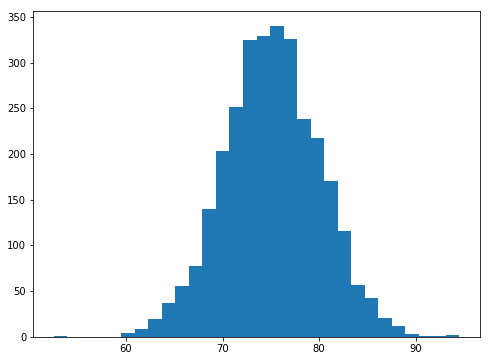

In [22]:
# now we can move onto actually calibrating a model rather than guessing the parameters!
# Here's a normal distribution
f, ax = plt.subplots(1,figsize=(8,6))
ax.hist(np.random.normal(75,5,3000),30);

Now here’s a Poisson distribution with the same mean:

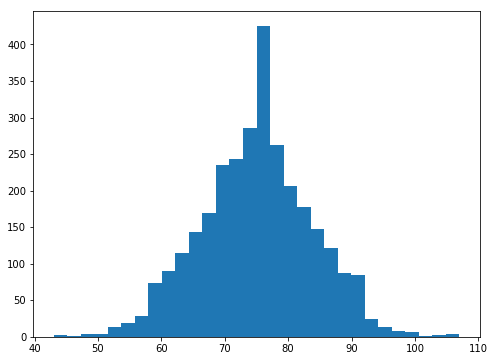

In [23]:
# poisson with mean of 75
f, ax = plt.subplots(1,figsize=(8,6))
ax.hist(np.random.poisson(75,3000),30);

Looks kind of similar doesn’t it! The thing with the Poisson distribution is, when the mean ($\lambda$ - lambda) changes, so does the distribution. As the mean gets smaller (and this is often the case with flow data where small flows are very likely - have a look at the ‘Total’ column in your cdata dataframe, lots of small numbers aren’t there?) the distribution starts to look a lot more like a skewed or log-normal distrbution. They key thing is it’s not - it’s a Poisson distribution. Here’s a similar frequency distribution with a small mean:

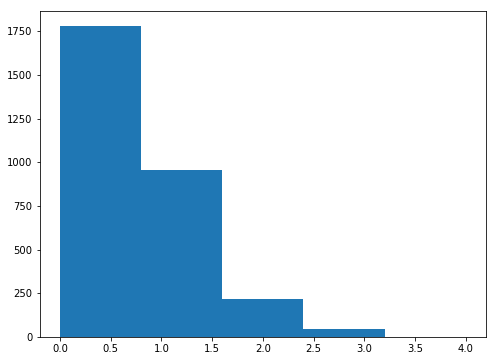

In [24]:
# poisson with mean of 0.5
f, ax = plt.subplots(1,figsize=(8,6))
ax.hist(np.random.poisson(0.5,3000),5);

As far as we’re concerned, what this means is that if we are interested in all flows between all origins and destinations in our system, these flows will have a mean value of $\lambda_{ij}$ and this will dictate the distribution. Here’s what the distrbution of our flows looks like:

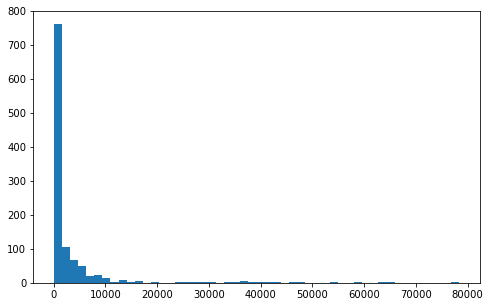

In [25]:
# Here's what our flows look like
# poisson with mean of 0.5
f, ax = plt.subplots(1,figsize=(8,5))
ax.hist(cdata['Total'],50);

So, what does all of this mean for our spatial interaction model?

Well the main thing it means is that Equation 5, for most sorts of spatial interaction models where we are modelling flows of people or whole things, is not correct.

By logging both sides of the equation in Equation 5, we are trying to get a situation where our $T_{ij}$ flows can be modelled by using the values of our other variables such as distance, by using a straight line a bit like this:

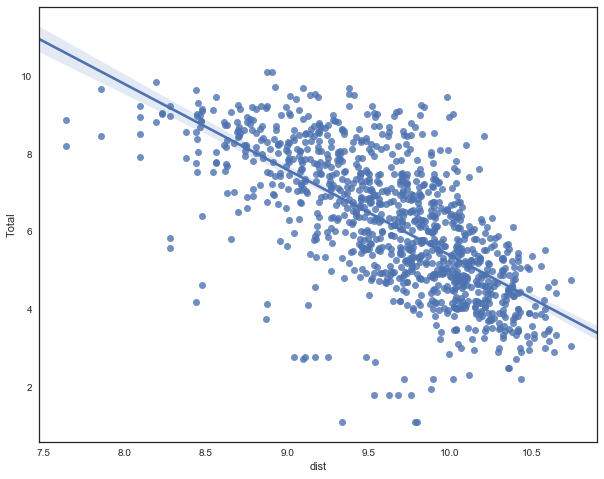

In [26]:
# Now, to estimate the log-log linear model of flows on distance we need to subset out the 0 values.
# Note that R seems to quietly handle this. It's clear that the data is excluded from the domain of the regression line.
# We'll use the seaborn package for this, which doesn't quietly handle zeroes!

# Do the subsetting.
cdata_graph = cdata[(cdata['Total'] > 0.0) & (cdata['dist'] > 0.0)]

# log the variables
log_total = np.log(cdata_graph['Total'])
log_dist = np.log(cdata_graph['dist'])

# Now use seaborn to make a nice plot.
import seaborn as sns
sns.set_style('white')
f, ax = plt.subplots(1,figsize=(10,8))
sns.regplot(x = log_dist, y = log_total, ax=ax);

If you compare this graph with the graph above (the first scatter plot we drew), it’s exactly the same data, but clearly by logging both the total and distance, we can get a bit closer to being able to fit a model estimate using a straight line.

What the Poisson distribution means is that the yy variable in our model is not logged as in the graph above, but it can still be modelled using something like the blue line - I hope that sort of makes sense. If not, don’t worry, just take it from me that this is good news.

## The Poisson Regression Spatial Interaction Model

So, we can now re-specify Equation 5 as a Poisson Regression model. Instead of our independent variable being $\ln T_{ij}$ our dependent variable is now the mean of our Poisson distribution $\lambda_{ij}$ and the model becomes:

6 $$\lambda_{ij} = \exp(k + \mu \ln V_{i} + \alpha \ln W_{j} - \beta \ln d_{ij})$$

What this model says is that $\lambda_{ij}$ (our independent variable - the estimate of $T_{ij}$) is is _logarithmically linked_ to (or modelled by) a linear combination of the logged independent variables in the model.

Now we have Equation 6 at our disposal, we can use a Poisson regression model to produce estimates of $k$, $\mu$, $\alpha$ and $\beta$ - or put another way, we can use the regression model to calibrate our parameters.

So, let’s have a go at doing it!!

It's very straightforward to run a Poisson regression model in python using the 'statsmodels' package using the 'generalised linear model' (GLM) approach. In a GLM, parameters are calibrated though an ‘iteratively re-weighted least squares’ algorithm. This algorithm does exaxtly the sort of job I described earlier, it fits lots of lines to the data, continually adjusting the parameters and then seeing if it can minimise the error between the observed and expected values useing some goodness-of-fit measure is maximised/minimised.

These sorts of algorithms have been around for years and are very well established so it makes sense to make use of them rather than trying to re-invent the wheel ourselves. So here we go…

In [27]:
# Time to actually specify a SIM using a Poisson GLM.
# We'll do this using statsmodels, and the formula approach.
# Here we're just using the 7 borough sub sample of data.
# First take logs of the relevant fields
cdatasub['log_vi1_origpop'] = np.log(cdatasub['vi1_origpop'])
cdatasub['log_wj2_destsal'] = np.log(cdatasub['wj2_destsal'])
cdatasub['log_dist'] = np.log(cdatasub['dist'])

formula = "Total ~ log_vi1_origpop + log_wj2_destsal + log_dist"
uncosim = smf.glm(formula=formula, data = cdatasub, family = sm.families.Poisson()).fit()
uncosim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -23011.
Date:                Tue, 23 Jan 2018   Deviance:                       45708.
Time:                        19:12:59   Pearson chi2:                 4.65e+04
No. Iterations:                     7                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -15.6402      0.177    -88.379      0.000     -15.987     -15.293
log_vi1_origpop     1.7488      0.012    140.279      0.000       1.724       1.773
log_wj2_destsal     1.6425      0.009    187.009      0.000       1.625       1.660
log_dist           -1.4123      0.007   -210.763      0.000      -1.425      -1.399
===================================================================================
"""

It’s a simple as that - runs in a matter of milliseconds. You should be able to see how the formula we define and pass to the GLM to solve corresponds to Equation 6.

Total = $T_{ij}$ = $\lambda_{ij}$
~ (tilde) means "is modelled by"
log_vi1_origpop = $\ln V_{i}$
log_wj2_destsal = $\ln W_{j}$
log_dist = $\ln d_{ij}$
family = sm.families.Poisson() means that we are using a Poisson regression model (the link is always log with a Poisson model) where the left-hand side of the model equation is logarithmically linked to the variables on the right-hand side.

Appending .fit() runs or "fits" the model, and calling the .summary() method on the results object uncosim gives us a neat little table of outcomes!

We can see from the summary that the Poisson regression has calibrated all 4 parameters for us and these appear under the ‘coef’ column, meaning "coefficient" - essentially the estimate.
* $k$ (Intercept) = -15.6402
* $\mu$ = 1.7488
* $\alpha$ = 1.6425
* $\beta$ = -1.4123

We can also see from the other outputs that all variables are highly significant (p < 0.000), with the z-scores revealing that distance has the most influence on the model (as we might have expected from the scatter plots we produced earlier which showed that distance had by far the strongest correlation with commuting flows).

These parameters are not too far away from our initial guesses of $\mu$ = 1, $\alpha$ = 1 and $\beta$ = -2. but how do the estimates compare?

We can put the parameters back into the spatial interaction model equation, as we did previously, however, python can do this for us if we use the .fittedvalues property of the uncosim result object.

In [28]:
# We can calculate the flow estimates by plugging the values here back into the multiplicative model
k = uncosim.params[0]
mu = uncosim.params[1]
alpha = uncosim.params[2]
beta = uncosim.params[3]

# here's how we get the model flows
unconstrained_est2_hard = np.exp(k + mu*cdatasub['log_vi1_origpop'] + alpha*cdatasub['log_wj2_destsal'] + beta*cdatasub['log_dist'])

# or simply use the model we have already built.
unconstrained_est2_easy = uncosim.fittedvalues

# Round to integers - we actually lose 4 people through rounding...
unconstrained_est2 = np.round(unconstrained_est2_easy,0)

In [29]:
# Attach these estimates back to cdatasub
cdatasub = cdatasub.assign(est2 = unconstrained_est2)

# Make a pivot table to look at the flow matrix
pd.pivot_table(cdatasub,values='est2',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,207.0,770.0,145.0,292.0,308.0,1262.0,2984.0
Barnet,1012.0,0.0,962.0,5689.0,913.0,6419.0,9563.0,24558.0
Bexley,2119.0,540.0,0.0,430.0,2170.0,869.0,3804.0,9932.0
Brent,588.0,4717.0,635.0,0.0,683.0,4964.0,7009.0,18596.0
Bromley,1460.0,931.0,3942.0,840.0,0.0,1559.0,6608.0,15340.0
Camden,622.0,2643.0,637.0,2465.0,629.0,0.0,15143.0,22139.0
City of London,21.0,32.0,23.0,28.0,22.0,123.0,0.0,249.0
All,5822.0,9070.0,6969.0,9597.0,4709.0,14242.0,43389.0,93798.0


Finally, let's check if the parameter calibration has improved our model

In [30]:
# Finally, let's look at the fit statistics!
calcR2(cdatasub['Total'],cdatasub['est2'])

0.67205308350527015

In [31]:
calcRMSE(cdatasub['Total'],cdatasub['est2'])

1895.752206532127

The $r^{2}$ has improved from 0.51 to 0.67 and the RMSE has reduced from 2502.00 to 1895.75 so by calibrating our parameters using the Poisson Regression Model, we have markedly improved our model fit.

But we can do even better. We have just been playing with the unconstrained model, by adding constraints into the model we can both improve our fit further AND start to do cool things like esimate transport trip distributions from know information about people leaving an area, or estimate the amount of money a shop is going to make from the available money that people in the surrounding area have to spend, or guess the number of migrants travelling between specific countries where we only know how many people in total leave one country and arrive in another.

We’ll do all of this in part 2 of these sessions.

## Extension ideas for this session:

1. Have a play around with inputting different parameter values and see what happens to the flow estimates - for example, what happens if you change the frictional effect of distance by increasing and decreasing the negative value of the $\beta$ parameter? Try some values of -2, -3, -4. What do positive values do to the flows?
2. What happens to the flow estimates if you adjust the other parameters in the model or remove $k$?
3. Try running the model on the whole London system - although you may run into problems if you don’t remove the intra-borough flows. This is because for intra-flows, the distance value is 0 and you can’t take the log of 0. To fix this, you can either change all of the zero distance values to something very small (like 1 or 0.5) or, alternatively, remove all rows in the data where origin = destination.
4. What might you expect to happen to the flows of people between, say, Camden and Brent if all of a sudden loads of really well paid jobs appeared in Brent and the average salary doubled? How might this impact the other Boroughs in the system?